In [ ]:
import os
import copy
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Data Preparation

* Loading the original data

In [ ]:
%%time
# Around 1mins
xlsx = pd.ExcelFile('ITU-AI-Challenge-Turkcell-RLF-training-data-v1.3.xlsx')
sheets = pd.read_excel(xlsx, sheet_name=None, index_col=0, 
                       na_filter=True, convert_float=False)

met_stations = sheets['met-stations']
met_real = sheets['met-real']
#met_forecast = sheets['met-forecast'].dropna() #Changed by JSP
met_forecast = sheets['met-forecast'] 
rl_sites = sheets['rl-sites']
rl_kpis = sheets['rl-kpis']
distances = sheets['distances']

# Station names
stations = met_stations['station_no'].tolist()

# Forecast dates
forecast_dates = sorted(list(set(met_forecast['datetime'])))

CPU times: user 5min 23s, sys: 3.35 s, total: 5min 27s
Wall time: 5min 29s


#### On MET Forecast
* One value per each (station_no, datetime)
* The value will be the mean of the values per each (station_no, datetime)
* One hot encoding for the categorical data
* **Only the forecast of the next day would be consider**

*Numerical data*

In [ ]:
met_forecast.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0.0,WS_17038,2019-01-02,evening,scattered clouds,15.0,10.0,74.0,50.0,188.0,15.0,rain,16.0,9.0,85.0,52.0,304.0,15.0,rain,10.0,6.0,86.0,70.0,154.0,15.0,rain,8.0,6.0,86.0,55.0,195.0,12.0,rain,6.0,4.0,83.0,78.0,177.0,11.0
1.0,WS_17038,2019-01-02,morning,scattered clouds,15.0,10.0,74.0,50.0,188.0,15.0,rain,16.0,9.0,85.0,52.0,304.0,15.0,rain,10.0,6.0,86.0,70.0,154.0,15.0,rain,8.0,6.0,86.0,55.0,195.0,12.0,rain,6.0,4.0,83.0,78.0,177.0,11.0
96.0,WS_17038,2019-01-03,evening,rain,17.0,10.0,86.0,51.0,107.0,20.0,rain,10.0,6.0,87.0,71.0,145.0,15.0,rain,9.0,7.0,87.0,67.0,251.0,12.0,rain,7.0,5.0,87.0,72.0,167.0,10.0,rain,7.0,5.0,82.0,77.0,173.0,16.0
97.0,WS_17038,2019-01-03,morning,rain,17.0,10.0,86.0,51.0,107.0,20.0,rain,10.0,6.0,87.0,71.0,145.0,15.0,rain,9.0,7.0,87.0,67.0,251.0,12.0,rain,7.0,5.0,87.0,72.0,167.0,10.0,rain,7.0,5.0,82.0,77.0,173.0,16.0
192.0,WS_17038,2019-01-04,evening,rain,10.0,6.0,NaN,NaN,NaN,NaN,rain,9.0,7.0,NaN,NaN,NaN,NaN,rain,7.0,5.0,NaN,NaN,NaN,NaN,rain,7.0,5.0,NaN,NaN,NaN,NaN,rain,7.0,4.0,NaN,NaN,NaN,NaN


In [ ]:
to_drop = [c for c in met_forecast.columns 
           if ('day1' not in c) and (c not in ['station_no', 'datetime', 'report_time'])]
met_forecast_v2 = met_forecast.drop(columns=to_drop)
met_forecast_v2.head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1
0.0,WS_17038,2019-01-02,evening,scattered clouds,15.0,10.0,74.0,50.0,188.0,15.0
1.0,WS_17038,2019-01-02,morning,scattered clouds,15.0,10.0,74.0,50.0,188.0,15.0
2.0,WS_17232,2019-01-02,evening,heavy rain showers,14.0,6.0,96.0,79.0,222.0,34.0
3.0,WS_17232,2019-01-02,morning,heavy rain showers,14.0,6.0,96.0,79.0,222.0,34.0
4.0,WS_17233,2019-01-02,evening,heavy rain showers,14.0,7.0,88.0,54.0,237.0,46.0


In [ ]:
mean_values = met_forecast_v2.groupby(by=['station_no', 'datetime']).mean().reset_index()
mean_values.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1
0,WS_17038,2019-01-02,15.0,10.0,74.0,50.0,188.0,15.0
1,WS_17038,2019-01-03,17.0,10.0,86.0,51.0,107.0,20.0
2,WS_17038,2019-01-04,10.0,6.0,NaN,NaN,NaN,NaN
3,WS_17038,2019-01-05,9.5,6.0,NaN,NaN,NaN,NaN
4,WS_17038,2019-01-06,9.0,6.0,86.0,75.0,322.0,10.0


*Categorical data*

In [ ]:
numerical_values = met_forecast_v2.describe().columns
non_num_df = met_forecast_v2[[x for x in met_forecast_v2.columns 
                              if x not in numerical_values]]
non_num_df.head()

,station_no,datetime,report_time,weather_day1
0.0,WS_17038,2019-01-02,evening,scattered clouds
1.0,WS_17038,2019-01-02,morning,scattered clouds
2.0,WS_17232,2019-01-02,evening,heavy rain showers
3.0,WS_17232,2019-01-02,morning,heavy rain showers
4.0,WS_17233,2019-01-02,evening,heavy rain showers


In [ ]:
# 'Report_time' will be dropped
ohe_df = copy.deepcopy(non_num_df[['station_no', 'datetime']])
for x in range(1):
  temp = pd.get_dummies(non_num_df[f'weather_day{x+1}'], prefix=f'wd{x+1}')
  ohe_df = pd.concat([ohe_df, temp], axis=1)
ohe_df.head()

,station_no,datetime,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0.0,WS_17038,2019-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1.0,WS_17038,2019-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2.0,WS_17232,2019-01-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.0,WS_17232,2019-01-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4.0,WS_17233,2019-01-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Dealing with two datetimes
ohe_df = ohe_df.groupby(by=['station_no', 'datetime'], as_index=False).agg(lambda x: 1 if sum(x) > 1 else sum(x))
ohe_df.head()

,station_no,datetime,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,WS_17038,2019-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,WS_17038,2019-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,WS_17038,2019-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,WS_17038,2019-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,WS_17038,2019-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


*Combining the numerical data with the categorical*

In [ ]:
modified_forecast_df = pd.merge(left=mean_values, right=ohe_df, on=['station_no', 'datetime'])
modified_forecast_df.head()

,station_no,datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,WS_17038,2019-01-02,15.0,10.0,74.0,50.0,188.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,WS_17038,2019-01-03,17.0,10.0,86.0,51.0,107.0,20.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,WS_17038,2019-01-04,10.0,6.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,WS_17038,2019-01-05,9.5,6.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,WS_17038,2019-01-06,9.0,6.0,86.0,75.0,322.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### On RL KPIS
* Using modified data provided by JSP
* Adding the forecast information from the nearest weather stations (from the previous day)
* Adding the KPI information from the previous day. (added by JSP)

In [ ]:
# To find nearest station
def find_nearest_stations(site_id: str, distances: pd.DataFrame, 
                          stations: list, k: int = 1) -> str:
  temp = distances[[site_id]].sort_values(by=[site_id])
  temp = temp.loc[[x for x in temp.index if x in stations]].head(k)
  return list(temp.index)

In [ ]:
%%time
# Around 1mins
xlsx = pd.ExcelFile('ITU-AI-Challenge-Turkcell-RLF-training-data-v1.3.xlsx')
rl_kpis_mod = pd.read_excel(xlsx, sheet_name='rl-kpis', index_col=0, 
                       na_filter=True, convert_float=False)
rl_sites = pd.read_excel(xlsx, sheet_name='rl-sites', index_col=0, 
                       na_filter=True, convert_float=False)

CPU times: user 5min 12s, sys: 2.29 s, total: 5min 14s
Wall time: 5min 16s


In [ ]:
# Some columns were dropped
rl_kpis_mod = rl_kpis_mod.drop(['direction','neid'], axis = 1) 
rl_kpis_mod.head()

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf
0.0,ENK,2019-01-02,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0.02461,406.0,512QAM(QO),False
1.0,ENK,2019-01-02,FAR,R1AG,227760.0,RL_I7LB>,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-35.4,NaN,154.0,128QAM,False
2.0,ENK,2019-01-02,NEAR,R1BA,345715.0,RL_I7LB>,NaN,cardtype2,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-40.4,NaN,154.0,128QAM,False
3.0,ENK,2019-01-02,NEAR,R0TR,265780.0,RL_I7T?Q,NaN,cardtype4,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-39.8,0,72.0,128QAM,False
4.0,NEC,2019-01-02,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.7,NaN,407.0,512QAM,False


In [ ]:
%%time
# Around 1hour16mins
# Forecast datetime should be - 1 day from the kpis datetime
rl_kpis_mod['forecast_datetime'] = [x - pd.Timedelta(days=1) for x in rl_kpis_mod['datetime']]

# Getting nearest station (just 1) based on the antennas - This might take a while
rl_kpis_mod['nearest_station'] = [find_nearest_stations(site_id, distances, stations)[0] for site_id in rl_kpis_mod['site_id']]

# Assuring the dates are timestamp type
modified_forecast_df['datetime'] = [pd.Timestamp(x) for x in modified_forecast_df['datetime']]
rl_kpis_mod['forecast_datetime'] = [pd.Timestamp(x) for x in rl_kpis_mod['forecast_datetime']]

# Modify name to merge
modified_forecast_df.rename(columns={'datetime':'forecast_datetime', 'station_no':'nearest_station'}, inplace=True) 

CPU times: user 1h 16min 35s, sys: 1.14 s, total: 1h 16min 36s
Wall time: 1h 16min 42s


In [ ]:
## KPI Historical (one day) (Added by JSP)
rl_kpis_history = rl_kpis_mod.copy()

# Dropping columns.
rl_kpis_history.drop(columns = ['forecast_datetime','nearest_station'],inplace=True)

# Assuring the dates are timestamp type
rl_kpis_history['datetime'] = [pd.Timestamp(x) for x in rl_kpis_history['datetime']]

# Adding with site data.
rl_kpis_history = rl_kpis_history.merge(rl_sites[['site_id','groundheight','clutter_class']], on='site_id')

# Renaming columns for merging.
rl_kpis_history.columns= ['history_{}'.format(column) for column in rl_kpis_history.columns]

rl_kpis_history

,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_polarization,history_card_type,history_adaptive_modulation,history_freq_band,history_link_length,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_scalibility_score,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
0,ENK,2019-01-02,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0.02461,406.0,512QAM(QO),False,54.9587,OPEN LAND
1,ENK,2019-01-03,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,54.9587,OPEN LAND
2,ENK,2019-01-04,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,54.9587,OPEN LAND
3,ENK,2019-01-05,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,54.9587,OPEN LAND
4,ENK,2019-01-06,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,54.9587,OPEN LAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840712,ENK,2019-12-29,NEAR,R3EF,1348289.0,RL_NMFX>,Vertical,cardtype2,Disable,f3,4788.0,0.0,0.0,0.0,86400.0,0.0,-35.4,NaN,45.0,16QAM,False,20.9998,OPEN LAND
840713,ENK,2019-12-30,NEAR,R3EF,1348289.0,RL_NMFX>,Vertical,cardtype2,Disable,f3,4788.0,0.0,0.0,0.0,86400.0,0.0,-35.4,NaN,45.0,16QAM,False,20.9998,OPEN LAND
840714,ENK,2019-12-31,NEAR,R3EF,1348289.0,RL_NMFX>,Vertical,cardtype2,Disable,f3,4788.0,0.0,0.0,0.0,86400.0,0.0,-35.4,NaN,45.0,16QAM,False,20.9998,OPEN LAND
840715,NEC,2019-12-30,NEAR,R1AX,1350506.0,RL_[MLLL,Vertical,cardtype5,Enable,f5,805.0,0.0,0.0,0.0,86400.0,0.0,-33.9,NaN,407.0,512QAM,False,1.0149,AVERAGE-MEDIUM URBAN


In [ ]:
## Debug Cell
rl_kpis_mod[rl_kpis_mod['rlf']== True]

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station
94.0,ENK,2019-01-02,FAR,R2TW,259378.0,RL_IATC?,NaN,cardtype2,Disable,f2,NaN,157.0,7240.0,11923.0,74477.0,33811.0,-80.9,NaN,154.0,128QAM,True,2019-01-01,WS_18047
108.0,ENK,2019-01-02,NEAR,R2WT,259378.0,RL_IAZ?@,NaN,cardtype2,Enable,f2,NaN,95.0,792.0,15038.0,71362.0,45077.0,-38.2,NaN,154.0,128QAM,True,2019-01-01,WS_18047
772.0,ENK,2019-01-02,NEAR,K3DA,310109.0,RL_JEC?P,NaN,cardtype2,Disable,f3,NaN,1.0,79.0,3158.0,83242.0,4691.0,-39.8,NaN,91.0,16QAM,True,2019-01-01,WS_18027
1341.0,ENK,2019-01-02,NEAR,R6DH,341745.0,RL_S7HJR,NaN,cardtype4,Enable,f3,NaN,180.0,960.0,472.0,85928.0,49124.0,-75.8,NaN,91.0,16QAM,True,2019-01-01,WS_17380
2546.0,ENK,2019-01-03,FAR,K7AJ,306647.0,RL_IASMP,NaN,cardtype2,Disable,f3,NaN,2.0,10.0,433.0,85967.0,834.0,-39.5,NaN,154.0,128QAM,True,2019-01-02,WS_18808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838826.0,ENK,2019-12-31,FAR,U3TI,262614.0,RL_K7ZAJ,Horizontal,cardtype1,Enable,f2,16781.0,41.0,92.0,1050.0,85350.0,264.0,-38.2,0,225.0,1024QAM,True,2019-12-30,WS_19246
839643.0,ENK,2019-12-31,FAR,R6WH,1378102.0,RL_SESAL,Vertical,cardtype2,Disable,f1,7010.0,0.0,1.0,1157.0,85243.0,158.0,-38.5,NaN,72.0,128QAM,True,2019-12-30,WS_18609
839871.0,NEC,2019-12-31,FAR,R3LF,1383515.0,RL_T?M?E,Vertical,cardtype5,Enable,f3,663.0,2122.0,3054.0,39768.0,86400.0,68945.0,-44.6,NaN,88.0,256QAM,True,2019-12-30,WS_17310
839875.0,ENK,2019-12-31,FAR,R2KO,305698.0,RL_TOS?E,Vertical,cardtype2,Disable,f5,388.0,0.0,1.0,30547.0,55853.0,202.0,-31.6,NaN,72.0,128QAM,True,2019-12-30,WS_18838


In [ ]:
## Replacing Nearest Stations without Forecast

# weather station names.
ws = [i for i in distances.index if 'WS' in i] 

# distances to weather stations with forecast.
ws_with_forecast = np.intersect1d(rl_kpis_mod['nearest_station'].unique(),modified_forecast_df['nearest_station'].unique())
distances_ws_with_forecast = distances.loc[ws,ws_with_forecast].copy()

# weather stations without forecast.
ws_without_forecast = np.setdiff1d(rl_kpis_mod['nearest_station'].unique(),modified_forecast_df['nearest_station'].unique())
ws_replacement = [(i,distances_ws_with_forecast.loc[i].index[distances_ws_with_forecast.loc[i].argmin()]) for i in ws_without_forecast]

# replacing in dataset.
for i in ws_replacement:
  rl_kpis_mod.loc[rl_kpis_mod['nearest_station'] == i[0],'nearest_station'] = i[1]

*Merging the datasets*

In [ ]:
### Some values seems to be dropped
merged_df = pd.merge(rl_kpis_mod, modified_forecast_df, 
                      on=['nearest_station','forecast_datetime'],
                      validate='m:m')
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,ENK,2019-01-03,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NEC,2019-01-03,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.9,NaN,407.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NEC,2019-01-03,NEAR,R0BJ,332142.0,RL_I:UJO,NaN,cardtype5,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-29.5,NaN,181.0,256QAM(Q),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENK,2019-01-03,FAR,R0DK,306403.0,RL_I;YNL,NaN,cardtype4,Enable,f4,NaN,0.0,0.0,0.0,86400.0,0.0,-36.0,0.00513,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENK,2019-01-03,FAR,R0ED,313790.0,RL_I;YNL,NaN,cardtype1,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-33.8,0,406.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803360,NEC,2019-12-31,NEAR,U3EF,153015.0,RL_W<HPP,Vertical,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
803361,NEC,2019-12-31,NEAR,U3EJ,153015.0,RL_W<HPP,Horizontal,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
803362,NEC,2019-12-31,FAR,U3MF,1349689.0,RL_W<LGV,Vertical,cardtype5,Enable,f3,2141.0,0.0,0.0,0.0,86400.0,0.0,-38.9,NaN,77.0,128QAM,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
803363,ENK,2019-12-31,NEAR,U3BG,290689.0,RL_W<ZCK,Vertical,cardtype4,Enable,f5,2048.0,0.0,0.0,0.0,86400.0,0.0,-39.5,0,327.0,128QAM,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
## Some additional values seem to be dropped
merged_df = merged_df.merge(rl_kpis_history,left_on=['mlid','forecast_datetime'],right_on=['history_mlid','history_datetime'],validate='m:m')
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_polarization,history_card_type,history_adaptive_modulation,history_freq_band,history_link_length,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_scalibility_score,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
0,ENK,2019-01-03,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0.02461,406.0,512QAM(QO),False,54.9587,OPEN LAND
1,NEC,2019-01-03,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.9,NaN,407.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-01-02,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.7,NaN,407.0,512QAM,False,91.0254,LOW-SPARSE URBAN
2,NEC,2019-01-03,NEAR,R0BJ,332142.0,RL_I:UJO,NaN,cardtype5,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-29.5,NaN,181.0,256QAM(Q),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-01-02,NEAR,R0BJ,332142.0,RL_I:UJO,NaN,cardtype5,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-30.0,NaN,181.0,256QAM(Q),False,3.9814,OPEN LAND
3,ENK,2019-01-03,FAR,R0DK,306403.0,RL_I;YNL,NaN,cardtype4,Enable,f4,NaN,0.0,0.0,0.0,86400.0,0.0,-36.0,0.00513,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,R0DK,306403.0,RL_I;YNL,NaN,cardtype4,Enable,f4,NaN,0.0,0.0,0.0,86400.0,0.0,-36.0,0.08543,406.0,512QAM(QO),False,56.9884,INDUSTRIAL & COMMERCIAL
4,ENK,2019-01-03,FAR,R0ED,313790.0,RL_I;YNL,NaN,cardtype1,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-33.8,0,406.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,R0ED,313790.0,RL_I;YNL,NaN,cardtype1,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-33.8,0.01847,406.0,512QAM,False,56.9884,INDUSTRIAL & COMMERCIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721422,NEC,2019-12-31,NEAR,U3EF,153015.0,RL_W<HPP,Vertical,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NEC,2019-12-30,NEAR,U3EF,153015.0,RL_W<HPP,Vertical,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.6,NaN,247.0,2048QAM*,False,238.9611,BUILTUP-VILLAGE
721423,NEC,2019-12-31,NEAR,U3EJ,153015.0,RL_W<HPP,Horizontal,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NEC,2019-12-30,NEAR,U3EJ,153015.0,RL_W<HPP,Horizontal,cardtype5,Enable,f2,11729.

In [ ]:
## Debug Cell
merged_df[merged_df['rlf']== True]

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_polarization,history_card_type,history_adaptive_modulation,history_freq_band,history_link_length,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_scalibility_score,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
524,ENK,2019-01-03,FAR,J9YZ,280856.0,RL_[ELER,NaN,cardtype4,Enable,f3,NaN,0.0,2.0,129.0,86271.0,219.0,-41.0,0,154.0,128QAM,True,2019-01-02,WS_17881,12.0,6.0,96.0,80.0,192.0,21.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,J9YZ,280856.0,RL_[ELER,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.0,0,154.0,128QAM,False,9.589670e+05,DENSE TREE
954,ENK,2019-01-03,FAR,K7AJ,306647.0,RL_IASMP,NaN,cardtype2,Disable,f3,NaN,2.0,10.0,433.0,85967.0,834.0,-39.5,NaN,154.0,128QAM,True,2019-01-02,WS_17233,14.0,7.0,88.0,54.0,237.0,46.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,K7AJ,306647.0,RL_IASMP,NaN,cardtype2,Disable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-39.5,NaN,154.0,128QAM,False,4.996200e+04,LOW-SPARSE URBAN
974,ENK,2019-01-03,FAR,K7BM,310098.0,RL_L?E?H,NaN,cardtype2,Enable,f3,NaN,0.0,10.0,161.0,86239.0,392.0,-45.7,NaN,154.0,128QAM,True,2019-01-02,WS_17233,14.0,7.0,88.0,54.0,237.0,46.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,K7BM,310098.0,RL_L?E?H,NaN,cardtype2,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-45.7,NaN,154.0,128QAM,False,2.509833e+06,DENSE TREE
1806,ENK,2019-01-03,NEAR,K3VD,161506.0,RL_O;SB>,NaN,cardtype2,Enable,f3,NaN,0.0,18.0,193.0,86207.0,1680.0,-48.2,NaN,95.0,16QAM,True,2019-01-02,WS_18426,12.0,4.0,96.0,77.0,233.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,NEAR,K3VD,161506.0,RL_O;SB>,NaN,cardtype2,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-48.2,NaN,95.0,16QAM,False,4.129710e+05,SPARSE TREE
2928,ENK,2019-01-04,FAR,K3BL,143602.0,RL_\7TPI,NaN,cardtype4,Enable,f2,NaN,1.0,192.0,3655.0,82745.0,1315.0,-40.4,0,180.0,256QAM,True,2019-01-03,WS_18427,11.0,3.0,90.0,51.0,244.0,13.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-03,FAR,K3BL,143602.0,RL_\7TPI,NaN,cardtype4,Enable,f2,NaN,0.0,0.0,0.0,86400.0,0.0,-40.4,0,180.0,256QAM,False,7.100134e+06,SPARSE TREE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719694,NEC,2019-12-31,FAR,R3LF,1383515.0,RL_T?M?E,Vertical,cardtype5,Enable,f3,663.0,2122.0,3054.0,39768.0,86400.0,68945.0,-44.6,NaN,88.0,256QAM,True,2019-12-30,WS_17310,18.0,9.0,84.0,70.0,127.0,17.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-12-30,FAR,R3LF,1383515.0,RL_T?M?E,Vertical,cardtype5,Enable,f3,663.0,909.0,1239.0,13846.0,86400.0,10753.0,-42.5,NaN,88.0,256QAM,True,4.996200e+00,AVERAGE-DENSE URBAN
719716,NEC,2019-12-31,NEAR,R3FL,1383515.0,RL_[MIK?,Vertical,cardtype5,Enable,f3,663.0,7.0,573.0,45526.0,86400.0,52995.0,-50.6,NaN,88.0,256QAM,True,2019-12-30,WS_17310,18.0,9.0,84.0,70.0,127.0,17.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-12-30,NEAR,R3FL,1383515.0,RL_[MIK?,Vertical,cardtype

In [ ]:
merged_df.to_csv('merged_data.csv')

#### On Merged dataset
* Dropping some links according to Amin's outlier RF Links analysis based on triangulation.
* Dropping some NA values
* Normalizing bbe and unavail_second
* Upsampling and downsampling based on the month

In [ ]:
to_delete = ['K3_MV', 'K3_DS', 'K3_AE', 'K3_CS', 'K3_DL']
merged_df = merged_df.loc[[x not in to_delete for x in merged_df['mlid_agnostic']]]

*Normalizing per link*

In [ ]:
mean_per_mlid = {mlid:merged_df[merged_df['mlid_original'] == mlid]['bbe'].mean() for mlid in list(set(merged_df['mlid_original']))}
std_per_mlid = {mlid:merged_df[merged_df['mlid_original'] == mlid]['bbe'].std() for mlid in list(set(merged_df['mlid_original']))}
merged_df['bbe_normalized'] = [(x - mean_per_mlid[mlid])/std_per_mlid[mlid] if std_per_mlid[mlid] > 0 else 0 for x, mlid in zip(merged_df['bbe'], merged_df['mlid_original'])]

In [ ]:
mean_per_mlid = {mlid:merged_df[merged_df['mlid_original'] == mlid]['unavail_second'].mean() for mlid in list(set(merged_df['mlid_original']))}
std_per_mlid = {mlid:merged_df[merged_df['mlid_original'] == mlid]['unavail_second'].std() for mlid in list(set(merged_df['mlid_original']))}
merged_df['unavail_second_normalized'] = [(x - mean_per_mlid[mlid])/std_per_mlid[mlid] if std_per_mlid[mlid] > 0 else 0 for x, mlid in zip(merged_df['unavail_second'], merged_df['mlid_original'])]

*Adding the month*

In [ ]:
merged_df['month'] = [pd.Timestamp(x).month for x in merged_df['datetime']]

*Handling mistaken entries* (Added by JSP)[To remove scalibility score = date].

In [ ]:
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_polarization,history_card_type,history_adaptive_modulation,history_freq_band,history_link_length,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_scalibility_score,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class,month
0,ENK,2019-01-03,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,NEAR,R0AP,314493.0,RL_9;SIP,NaN,cardtype4,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-41.6,0.02461,406.0,512QAM(QO),False,54.9587,OPEN LAND,1
1,NEC,2019-01-03,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.9,NaN,407.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-01-02,NEAR,R1TP,335068.0,RL_I7Z?H,NaN,cardtype5,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-34.7,NaN,407.0,512QAM,False,91.0254,LOW-SPARSE URBAN,1
2,NEC,2019-01-03,NEAR,R0BJ,332142.0,RL_I:UJO,NaN,cardtype5,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-29.5,NaN,181.0,256QAM(Q),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NEC,2019-01-02,NEAR,R0BJ,332142.0,RL_I:UJO,NaN,cardtype5,Enable,f5,NaN,0.0,0.0,0.0,86400.0,0.0,-30.0,NaN,181.0,256QAM(Q),False,3.9814,OPEN LAND,1
3,ENK,2019-01-03,FAR,R0DK,306403.0,RL_I;YNL,NaN,cardtype4,Enable,f4,NaN,0.0,0.0,0.0,86400.0,0.0,-36.0,0.00513,406.0,512QAM(QO),False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,R0DK,306403.0,RL_I;YNL,NaN,cardtype4,Enable,f4,NaN,0.0,0.0,0.0,86400.0,0.0,-36.0,0.08543,406.0,512QAM(QO),False,56.9884,INDUSTRIAL & COMMERCIAL,1
4,ENK,2019-01-03,FAR,R0ED,313790.0,RL_I;YNL,NaN,cardtype1,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-33.8,0,406.0,512QAM,False,2019-01-02,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ENK,2019-01-02,FAR,R0ED,313790.0,RL_I;YNL,NaN,cardtype1,Enable,f3,NaN,0.0,0.0,0.0,86400.0,0.0,-33.8,0.01847,406.0,512QAM,False,56.9884,INDUSTRIAL & COMMERCIAL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721422,NEC,2019-12-31,NEAR,U3EF,153015.0,RL_W<HPP,Vertical,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NEC,2019-12-30,NEAR,U3EF,153015.0,RL_W<HPP,Vertical,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.6,NaN,247.0,2048QAM*,False,238.9611,BUILTUP-VILLAGE,12
721423,NEC,2019-12-31,NEAR,U3EJ,153015.0,RL_W<HPP,Horizontal,cardtype5,Enable,f2,11729.0,0.0,0.0,0.0,86400.0,0.0,-41.3,NaN,247.0,2048QAM*,False,2019-12-30,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NEC,2019-12-30,NEAR,U3EJ,153015.0,RL_W<HPP,Horizontal,car

In [ ]:
## Debug Cell


*NA values*

In [ ]:
# Check for NA values
merged_df.columns[merged_df.isnull().any()]

Index(['polarization', 'freq_band', 'link_length', 'scalibility_score',
       'humidity_max_day1', 'humidity_min_day1', 'wind_dir_day1',
       'wind_speed_day1', 'history_polarization', 'history_freq_band',
       'history_link_length', 'history_scalibility_score',
       'history_clutter_class'],
      dtype='object')

In [ ]:
# 2442 entries are dropped #Changed to 460 when JSP was testing
merged_df['polarization'] = merged_df['polarization'].fillna('None')
merged_df['history_polarization'] = merged_df['history_polarization'].fillna('None')
merged_df['freq_band'] = merged_df['freq_band'].fillna('None')
merged_df['history_freq_band'] = merged_df['history_freq_band'].fillna('None')
merged_df['history_clutter_class'] = merged_df['history_clutter_class'].fillna('None')
merged_df['scalibility_score'] = merged_df['scalibility_score'].fillna(-1)
merged_df['history_scalibility_score'] = merged_df['history_scalibility_score'].fillna(-1)
df = merged_df.copy() #df = merged_df.dropna()
print(merged_df.shape[0] - df.shape[0])

0


In [ ]:
df.head()

,type,datetime,tip,mlid,mw_connection_no,site_id,polarization,card_type,adaptive_modulation,freq_band,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_polarization,history_card_type,history_adaptive_modulation,history_freq_band,history_link_length,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_scalibility_score,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class,month
649580,NEC,2019-11-13,FAR,R6CF,317524.0,RL_IBVL>,None,cardtype5,Enable,f3,2521.0,0.0,0.0,0.0,86400.0,0.0,-41.4,-1,407.0,512QAM,False,2019-11-12,WS_18016,26.0,12.0,72.0,27.0,169.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NEC,2019-11-12,FAR,R6CF,317524.0,RL_IBVL>,Vertical,cardtype5,Enable,f3,2521.0,0.0,0.0,0.0,86400.0,0.0,-41.5,-1,407.0,512QAM,False,22.0147,OPEN IN URBAN,11
649581,NEC,2019-11-13,NEAR,R1SN,314937.0,RL_ID2GJ,None,cardtype5,Enable,f3,1300.0,0.0,0.0,0.0,86400.0,0.0,-39.3,-1,247.0,2048QAM*,False,2019-11-12,WS_18016,26.0,12.0,72.0,27.0,169.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NEC,2019-11-12,NEAR,R1SN,314937.0,RL_ID2GJ,Vertical,cardtype5,Enable,f3,1300.0,0.0,0.0,0.0,86400.0,0.0,-39.7,-1,247.0,2048QAM*,False,102.9695,INDUSTRIAL & COMMERCIAL,11
649582,NEC,2019-11-13,NEAR,R0CG,340722.0,RL_IDBQ?,None,cardtype5,Enable,f5,702.0,0.0,0.0,0.0,86400.0,0.0,-29.3,-1,495.0,2048QAM*,False,2019-11-12,WS_18016,26.0,12.0,72.0,27.0,169.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NEC,2019-11-12,NEAR,R0CG,340722.0,RL_IDBQ?,Vertical,cardtype5,Enable,f5,702.0,0.0,0.0,0.0,86400.0,0.0,-29.5,-1,495.0,2048QAM*,False,49.0257,INDUSTRIAL & COMMERCIAL,11
649583,NEC,2019-11-13,NEAR,R1KE,168406.0,RL_IDC?I,None,cardtype5,Enable,f3,1286.0,0.0,0.0,0.0,86400.0,0.0,-37.2,-1,247.0,2048QAM*,False,2019-11-12,WS_18016,26.0,12.0,72.0,27.0,169.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NEC,2019-11-12,NEAR,R1KE,168406.0,RL_IDC?I,Vertical,cardtype5,Enable,f3,1286.0,0.0,0.0,0.0,86400.0,0.0,-38.3,-1,247.0,2048QAM*,False,301.9606,INDUSTRIAL & COMMERCIAL,11
649584,NEC,2019-11-13,NEAR,R0BL,332953.0,RL_IDECS,None,cardtype5,Enable,f4,807.0,0.0,0.0,0.0,86400.0,0.0,-45.6,-1,203.0,512QAM,False,2019-11-12,WS_18016,26.0,12.0,72.0,27.0,169.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NEC,2019-11-12,NEAR,R0BL,332953.0,RL_IDECS,Vertical,cardtype5,Enable,f4,807.0,0.0,0.0,0.0,86400.0,0.0,-44.9,-1,203.0,512QAM,False,90.0105,LOW-DENSE URBAN,11


*Dealing with month's distribution*

In [ ]:
# Months distribution
print(pd.DataFrame.from_dict(Counter(df['month']), orient='index').sort_values(by=0))
month_dist = dict(Counter(df['month']))
print(month_dist)

        0
12   7569
6   10549
8   10687
11  13408
9   15277
10  16789
7   17594
{6: 10549, 7: 17594, 8: 10687, 9: 15277, 10: 16789, 11: 13408, 12: 7569}


In [ ]:
'''
* Upsample: December [12]
* Downsample: July [7], September [9], October [10]
'''
from statistics import mean 
middle_ground = mean([month_dist[k] for k in month_dist.keys() if k in [6,11,8]])
middle_ground = int(round(middle_ground, -1))
print(middle_ground)

7880


In [ ]:
# Downsampling July [7], September [9], October [10]
sampled_df = copy.deepcopy(df.loc[[x in [6, 8, 11] for x in df['month']]])
for m in [7, 9, 10]:
  temp = df.loc[df['month'] == m]
  temp = temp.sample(middle_ground)
  sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
# Upsampling December [12] - NAIVE APPROACH
december = df.loc[df['month'] == 12]
temp = december.sample(n=middle_ground, replace=True)
sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
Counter(sampled_df['month'])

Counter({6: 7414, 7: 7880, 8: 8000, 9: 7880, 10: 7880, 11: 8225, 12: 7880})

*Dealing with more categorical data*

In [ ]:
# One hot encoding
columns_to_ohe = ['type', 'tip', 'polarization', 'card_type', 'adaptive_modulation', 'freq_band', 'modulation',
                  'history_type', 'history_tip', 'history_polarization', 'history_card_type', 'history_adaptive_modulation', 'history_freq_band', 'history_modulation',
                  'history_clutter_class']
# df = copy.deepcopy(sampled_df) # Edited by JSP
df = copy.deepcopy(df)
for c in columns_to_ohe:
  temp = pd.get_dummies(df[c], prefix=c).astype('int')
  df = df.drop(columns=c)
  df = pd.concat([df, temp], axis=1)

In [ ]:
# df.to_csv('data_v2.csv', index=False) # Edited by JSP
df.to_csv('TRAINING_v1_NoSampling.csv', index=False)

## Model Development

In [ ]:
df = pd.read_csv('TRAINING_v1_NoSampling.csv')
df.head()
df

,datetime,mlid,mw_connection_no,site_id,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,...,history_freq_band_f5,history_modulation_1024 QAM,history_modulation_1024QAM,history_modulation_128QAM,history_modulation_128QAM(Q),history_modulation_128QAM-XPIC,history_modulation_16QAM,history_modulation_16QAM(Q),history_modulation_2048QAM,history_modulation_2048QAM*,history_modulation_256QAM,history_modulation_256QAM(Q),history_modulation_256QAM(QO),history_modulation_32QAM,history_modulation_4QAM,history_modulation_512QAM,history_modulation_512QAM(QO),history_modulation_64QAM,history_modulation_64QAM(Q),history_modulation_C-QPSK,history_clutter_class_AVERAGE-DENSE URBAN,history_clutter_class_AVERAGE-MEDIUM URBAN,history_clutter_class_AVERAGE-SPARSE URBAN,history_clutter_class_BUILTUP-VILLAGE,history_clutter_class_CITY WALLS,history_clutter_class_DENSE TREE,history_clutter_class_GREEN HOUSE,history_clutter_class_HIGH-DENSE URBAN,history_clutter_class_HIGH-ISOLATED-BUILDINGS,history_clutter_class_HIGH-MEDIUM URBAN,history_clutter_class_HIGH-SPARSE URBAN,history_clutter_class_INDUSTRIAL & COMMERCIAL,history_clutter_class_LOW-DENSE URBAN,history_clutter_class_LOW-MEDIUM URBAN,history_clutter_class_LOW-SPARSE URBAN,history_clutter_class_None,history_clutter_class_OPEN IN URBAN,history_clutter_class_OPEN LAND,history_clutter_class_SPARSE TREE,history_clutter_class_VERYHIGH-SPARSE BLOCK BUILDINGS
0,1/3/2019,R0AP,314493,RL_9;SIP,NaN,0,0,0,86400,0,-41.6,0.00000,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1/3/2019,R1TP,335068,RL_I7Z?H,NaN,0,0,0,86400,0,-34.9,-1.00000,407,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1/3/2019,R0BJ,332142,RL_I:UJO,NaN,0,0,0,86400,0,-29.5,-1.00000,181,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1/3/2019,R0DK,306403,RL_I;YNL,NaN,0,0,0,86400,0,-36.0,0.00513,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1/3/2019,R0ED,313790,RL_I;YNL,NaN,0,0,0,86400,0,-33.8,0.00000,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721420,12/31/2019,U3EF,153015,RL_W<HPP,11729.0,0,0,0,86400,0,-41.3,-1.00000,247,False,12/30/2019,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
721421,12/31/2019,U3EJ,153015,RL_W<HPP,11729.0,0,0,0,86400,0,-41.3,-1.00000,247,False,12/30/2019,WS_17775,12.0,6.0,91.0,78.0,198.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
721422,12/31/2019,U3MF,1349689,RL_W<L

In [ ]:
# ## Keeping the mlids of troublesome links.
trouble_links = df[df['rlf'] == True]['mlid'].unique()
df = df[df['mlid'].isin(trouble_links)].copy()
df

,datetime,mlid,mw_connection_no,site_id,link_length,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy snow,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,...,history_freq_band_f5,history_modulation_1024 QAM,history_modulation_1024QAM,history_modulation_128QAM,history_modulation_128QAM(Q),history_modulation_128QAM-XPIC,history_modulation_16QAM,history_modulation_16QAM(Q),history_modulation_2048QAM,history_modulation_2048QAM*,history_modulation_256QAM,history_modulation_256QAM(Q),history_modulation_256QAM(QO),history_modulation_32QAM,history_modulation_4QAM,history_modulation_512QAM,history_modulation_512QAM(QO),history_modulation_64QAM,history_modulation_64QAM(Q),history_modulation_C-QPSK,history_clutter_class_AVERAGE-DENSE URBAN,history_clutter_class_AVERAGE-MEDIUM URBAN,history_clutter_class_AVERAGE-SPARSE URBAN,history_clutter_class_BUILTUP-VILLAGE,history_clutter_class_CITY WALLS,history_clutter_class_DENSE TREE,history_clutter_class_GREEN HOUSE,history_clutter_class_HIGH-DENSE URBAN,history_clutter_class_HIGH-ISOLATED-BUILDINGS,history_clutter_class_HIGH-MEDIUM URBAN,history_clutter_class_HIGH-SPARSE URBAN,history_clutter_class_INDUSTRIAL & COMMERCIAL,history_clutter_class_LOW-DENSE URBAN,history_clutter_class_LOW-MEDIUM URBAN,history_clutter_class_LOW-SPARSE URBAN,history_clutter_class_None,history_clutter_class_OPEN IN URBAN,history_clutter_class_OPEN LAND,history_clutter_class_SPARSE TREE,history_clutter_class_VERYHIGH-SPARSE BLOCK BUILDINGS
0,1/3/2019,R0AP,314493,RL_9;SIP,NaN,0,0,0,86400,0,-41.6,0.0,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1/3/2019,R0ED,313790,RL_I;YNL,NaN,0,0,0,86400,0,-33.8,0.0,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,1/3/2019,R0KS,1348426,RL_I;YNL,NaN,0,0,0,86400,0,-33.2,-1.0,407,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,1/3/2019,R0NQ,313790,RL_I;YNL,NaN,0,0,0,86400,0,-31.3,0.0,406,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,1/3/2019,R0XD,1348426,RL_I;YNL,NaN,0,0,0,86400,0,-33.2,-1.0,407,False,1/2/2019,WS_17300,14.0,6.0,95.0,58.0,184.0,47.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721409,12/31/2019,K7LC,145744,RL_V7[WF,2287.0,0,0,0,86400,0,-45.4,0.0,406,False,12/30/2019,WS_17860,14.0,3.0,90.0,54.0,59.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
721411,12/31/2019,K7ZV,283427,RL_VPI?P,4303.0,0,0,0,86400,0,-40.7,0.0,91,False,12/30/2019,WS_17860,14.0,3.0,90.0,54.0,59.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
721420,12/31/2019,U3EF,153015,RL_W<HPP,11729.0,0,0,0,86400,0,-41.3,-

In [ ]:
## Remove outliers having unavail_seconds = 86400
outofservice_samples = df[df['mlid'].isin(['K7_DP', 'K7_PD','K7_IS','K7_SI','K7_CI','K7_IC'])
                        & (df['unavail_second'] == 86400)]
df.drop(outofservice_samples.index,inplace=True)

In [ ]:
df['link_length'] = df['link_length'].fillna('-1')
df['humidity_max_day1'] = df['humidity_max_day1'].fillna('-1')
df['humidity_min_day1'] = df['humidity_min_day1'].fillna('-1')
df['wind_dir_day1'] = df['wind_dir_day1'].fillna('-1')
df['wind_speed_day1'] = df['wind_speed_day1'].fillna('-1')
df['history_link_length'] = df['history_link_length'].fillna('-1')

#### Train/Test split
* The split is made per each month

In [ ]:
# To split the dataframe into train set and test set by some column
def train_eval_split(df: pd.DataFrame, column: str, train_ratio: float = 0.7):
  if train_ratio > 1:
    raise ValueError(f'train ration cannot be {train_ratio}')
    
  train_df = pd.DataFrame([], columns=df.columns)
  test_df = pd.DataFrame([], columns=df.columns)
  for c in set(df[column]):
    temp = df.loc[df[column] == c]
    #temp = temp.sort_values(by='datetime').reset_index(drop=True)
    temp = temp.sample(temp.shape[0]).reset_index(drop=True)

    l = temp.shape[0]
    n = int(l * train_ratio)

    train_df = pd.concat([train_df, temp.iloc[:n]], axis=0)
    test_df = pd.concat([test_df, temp.iloc[n:]], axis=0)

  return train_df, test_df

*Processing the data for the model*

In [ ]:
train_df, test_df = train_eval_split(df=df, column='month')

# Drop some non-important columns
to_drop = ['datetime', 'mlid', 'mw_connection_no',
           'site_id', 'scalibility_score','severaly_error_second', 'error_second', 'avail_time', 
           'forecast_datetime', 'nearest_station', 'month', 
          #  'temp_max_day1', 'temp_min_day1', 'humidity_max_day1', 'humidity_min_day1',
          #  'wind_dir_day1', 'wind_speed_day1', 'wd1_clear sky', 'wd1_few clouds',
          #  'wd1_foggy', 'wd1_heavy rain showers','wd1_heavy thunderstorm with rain showers', 'wd1_hot day',
          #  'wd1_light intensity shower rain', 'wd1_light rain showers',
          #  'wd1_misty', 'wd1_overcast clouds', 'wd1_scattered clouds', 'wd1_sleet',
          #  'wd1_thunderstorm with heavy rain'
           'history_datetime','history_mlid','history_mw_connection_no',
           'history_site_id', 'history_scalibility_score', 'history_avail_time',
           'history_datetime'
           ]           
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

# Select the target
target = 'rlf'
candidates = ['rlf', 'bbe', 'unavail_second']

train_df = train_df.drop(columns=[c for c in candidates if c != target])
test_df = test_df.drop(columns=[c for c in candidates if c != target])

all_features = [c for c in train_df.columns if c != target]

In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

#### Label Distribution 

In [ ]:
len(df[df['rlf'] == True])

2264

Text(0.5, 1.0, 'Test set labels')

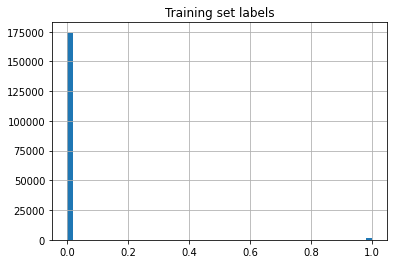

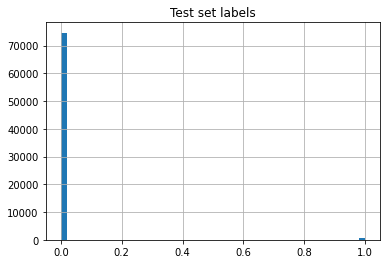

In [ ]:
# Observe the distribution of the labels.
plt.figure()
pd.Series(y).hist(bins=50)
plt.title("Training set labels")
plt.figure()
pd.Series(y_test).hist(bins=50)
plt.title("Test set labels")

#### Scikit-Learn Decision Tree Classification

[Text(236.025, 203.85, 'X[15] <= 0.5\ngini = 0.499\nsamples = 175737\nvalue = [1741.47, 1574.1]'),
 Text(167.85, 176.67000000000002, 'X[27] <= 0.5\ngini = 0.469\nsamples = 167978\nvalue = [1669.68, 999.9]'),
 Text(98.10000000000001, 149.49, 'X[32] <= 68.5\ngini = 0.429\nsamples = 142273\nvalue = [1416.27, 639.54]'),
 Text(56.7, 122.31, 'X[37] <= 2278.015\ngini = 0.408\nsamples = 140012\nvalue = [1394.49, 557.37]'),
 Text(28.8, 95.13, 'X[1] <= -25.15\ngini = 0.442\nsamples = 101059\nvalue = [1005.59, 495.0]'),
 Text(14.4, 67.94999999999999, 'X[24] <= 0.5\ngini = 0.432\nsamples = 100160\nvalue = [996.95, 460.35]'),
 Text(7.2, 40.77000000000001, 'X[6] <= 79.5\ngini = 0.399\nsamples = 67144\nvalue = [668.87, 254.43]'),
 Text(3.6, 13.590000000000003, 'gini = 0.376\nsamples = 62328\nvalue = [621.18, 207.9]'),
 Text(10.8, 13.590000000000003, 'gini = 0.5\nsamples = 4816\nvalue = [47.69, 46.53]'),
 Text(21.6, 40.77000000000001, 'X[10] <= 0.5\ngini = 0.474\nsamples = 33016\nvalue = [328.08, 205.

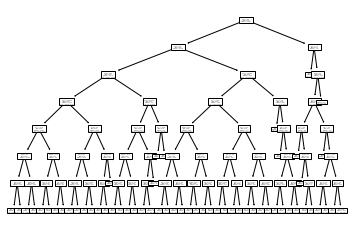

In [ ]:
# use decision tree
from sklearn import tree
dtree_clf = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.01,1:0.99})
dtree_clf.fit(x,y)

tree.plot_tree(dtree_clf) 
# dotfile = StringIO() 
# export_graphviz(dtree_reg, out_file=dotfile,feature_names=vectorizer.get_feature_names()) 
#pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png("my_tree.png")    

# Export graph with time and date in filename. Added by JSP.
# import time
# timestr = time.strftime("%Y%m%d")
# pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(timestr + "_event_class_decision_tree.png")

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

#1. Resubstitution Error.
resuberror = accuracy_score(y, dtree_clf.predict(x)) 
print("resuberror= %0.4f" % (1- resuberror))

#2. Cross-Validation Error (Kfold = 10).
print("random_state = " + str(dtree_clf.random_state))
cverror = cross_val_score(dtree_clf, x, y,cv=10, scoring='accuracy')
print("cverror= %0.4f (+/- %0.4f)" % (1-cverror.mean(), cverror.std()))

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf.predict(x_test)))
class_report = classification_report(y_test, dtree_clf.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf.predict(x_test[:1,:])

resuberror= 0.0987
random_state = 1555
cverror= 0.1392 (+/- 0.0740)
testerror= 0.1023

Confusion matrix for test set:
[[67222  7430]
 [  276   398]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   0.90     0.95   74652
1           1.0      0.05   0.59     0.09     674
2     macro avg      0.52   0.75     0.52   75326
3  weighted avg      0.99   0.90     0.94   75326

Computation time per sample:
The slowest run took 5.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 58 µs per loop


In [ ]:
'''
Source: 
https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
'''
def tree_to_rules(dt, all_features):
  tree_ = dt.tree_
  feature_names = [
                   all_features[i] if i != tree._tree.TREE_UNDEFINED else 'undefined' 
                   for i in tree_.feature
  ]

  def recurse(node, depth):
    indent = "- " * depth
    if tree_.feature[node] != tree._tree.TREE_UNDEFINED:
      name = feature_names[node]
      threshold = tree_.threshold[node]
      print(f"{indent}if {name} <= {threshold:.2f}:")
      recurse(tree_.children_left[node], depth + 1)
      print(f"{indent}else:  # if {name} > {threshold:.2f}")
      recurse(tree_.children_right[node], depth + 1)
    else:
      print(f"{indent}return >>> {tree_.value[node]}")

  recurse(0, 0)

tree_to_rules(dtree_clf, all_features)

Post-prunning

In [ ]:
## Finding best level for pruning.

pru_level = list(range(1,25))
pru_level.append(None)
cverror_vector = np.empty((len(pru_level),2),float)

#1. Print random seed.
print("random_state = " + str(dtree_clf.random_state))

#2. Grow the tree with different prunning levels and compute cross-validation error.
j = 0
for i in pru_level:
    dtree_clf = dtree_clf.set_params(max_depth = i, random_state=dtree_clf.random_state)
    cverror = cross_val_score(dtree_clf, x, y,cv=10, scoring='recall')
    cverror_vector[j,:] = [-cverror.mean(), cverror.std()]
    j = j+1
    if (type(i) == int):
        print("max_depth = %i \t\t-> cverror= %0.4f (+/- %0.4f)" % (i, cverror.mean(), cverror.std()))
    else:
        print("max_depth = Unlimited \t-> cverror= %0.4f (+/- %0.4f)" % (cverror.mean(), cverror.std()))

#3. Detect smallest tree within one standard error of the minimum crossvalidation error.
cv_error_vector_min = cverror_vector[:,0].min()
index_min_cverror = np.nonzero(cverror_vector[:,0] <= cv_error_vector_min) # Threshold with minimum error.
cv_error_vector_min = cv_error_vector_min + cverror_vector[index_min_cverror[0][0],1] # Increase tolerance of minimum error by one standard error.
index_min_cverror = np.nonzero(cverror_vector[:,0] <= cv_error_vector_min) # Threshold with new value.
BestLevel = pru_level[index_min_cverror[0][0]]
print("BestLevel = " + str(BestLevel))

random_state = 1555
max_depth = 1 		-> cverror= 0.3648 (+/- 0.2371)
max_depth = 2 		-> cverror= 0.5302 (+/- 0.2147)
max_depth = 3 		-> cverror= 0.5969 (+/- 0.2162)
max_depth = 4 		-> cverror= 0.5686 (+/- 0.1592)
max_depth = 5 		-> cverror= 0.5786 (+/- 0.1872)
max_depth = 6 		-> cverror= 0.5648 (+/- 0.1806)
max_depth = 7 		-> cverror= 0.5440 (+/- 0.1950)
max_depth = 8 		-> cverror= 0.5465 (+/- 0.1849)
max_depth = 9 		-> cverror= 0.5333 (+/- 0.1831)


In [ ]:
## Debug Cell
clf_tree

NameError: ignored

In [ ]:
pruned_tree_features = np.array(all_features)[dtree_clf.feature_importances_ > 0]
pruned_tree_features

array(['rxlevmax', 'capacity', 'temp_max_day1', 'temp_min_day1',
       'humidity_max_day1', 'humidity_min_day1', 'wind_dir_day1',
       'wind_speed_day1', 'wd1_few clouds', 'wd1_heavy rain',
       'wd1_heavy rain showers',
       'wd1_heavy thunderstorm with rain showers', 'wd1_overcast clouds',
       'wd1_scattered clouds', 'wd1_thunderstorm with heavy rain',
       'history_link_length', 'history_unavail_second', 'history_bbe',
       'history_rxlevmax', 'history_capacity', 'history_groundheight',
       'polarization_Vertical', 'card_type_cardtype2',
       'card_type_cardtype5', 'history_card_type_cardtype4',
       'history_adaptive_modulation_Enable', 'history_freq_band_f5',
       'history_modulation_128QAM',
       'history_clutter_class_HIGH-ISOLATED-BUILDINGS'], dtype='<U53')

Simplifying the Model

In [ ]:
to_keep = pruned_tree_features.tolist()
to_keep.append('rlf')

train_df = train_df.loc[:,to_keep]
test_df = test_df.loc[:,to_keep]

# Select the target
target = 'rlf'


In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

In [ ]:
# use decision tree
dtree_clf = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.01,1:0.99})
dtree_clf.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.01, 1: 0.99},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1555,
                       splitter='best')

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf.predict(x_test)))
class_report = classification_report(y_test, dtree_clf.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf.predict(x_test[:1,:])

testerror= 0.1562

Confusion matrix for test set:
[[63111 11542]
 [  225   448]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   0.85     0.91   74653
1           1.0      0.04   0.67     0.07     673
2     macro avg      0.52   0.76     0.49   75326
3  weighted avg      0.99   0.84     0.91   75326

Computation time per sample:
The slowest run took 18.75 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 56.1 µs per loop


Exporting the Model

In [ ]:
import joblib
joblib.dump(dtree_clf,'20201029_dtree_clf_v4_NoSampling')
joblib.dump(pruned_tree_features,'20201029_dtree_clf_v4_NoSampling_inputfeatures')



['20201029_dtree_clf_v4_NoSampling_inputfeatures']

In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 2.3MB/s 
     |████████████████████████████████| 163kB 8.5MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=7ef3ece061510e3881e36230bd587b7a96d1339896ecaad44670b0aa41461e74
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [ ]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=15, population_size=15, verbosity=2, scoring='balanced_accuracy', cv=10, random_state=1555)
tpot.fit(x, y)
print(tpot.score(x_test, y_test))
print(confusion_matrix(y_test, tpot.predict(x_test)))


Generation 1 - Current best internal CV score: 0.6485392181268748

Generation 2 - Current best internal CV score: 0.6485392181268748

Generation 3 - Current best internal CV score: 0.6813062368682052

Generation 4 - Current best internal CV score: 0.6813062368682052

Generation 5 - Current best internal CV score: 0.6813062368682052

Generation 6 - Current best internal CV score: 0.6854765445007159

Generation 7 - Current best internal CV score: 0.6854765445007159

Generation 8 - Current best internal CV score: 0.695278835881887

Generation 9 - Current best internal CV score: 0.695278835881887

Generation 10 - Current best internal CV score: 0.6985523151423267

Generation 11 - Current best internal CV score: 0.6985523151423267

Generation 12 - Current best internal CV score: 0.6985523151423267

Generation 13 - Current best internal CV score: 0.6985523151423267

Generation 14 - Current best internal CV score: 0.6985523151423267

Generation 15 - Current best internal CV score: 0.69855231

In [ ]:
tpot.export('tpot_classifier_rlf_ituchallenge_pipeline.py')